## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-outdoor' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_diagonal_wavelet_outdoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/outdoor/wavelet/diagonal/gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 2446,
 3: 9784,
 4: 39136,
 5: 156544,
 6: 626176,
 7: 2504704,
 8: 10018816,
 9: 40075264}

Running 12760 CDFs


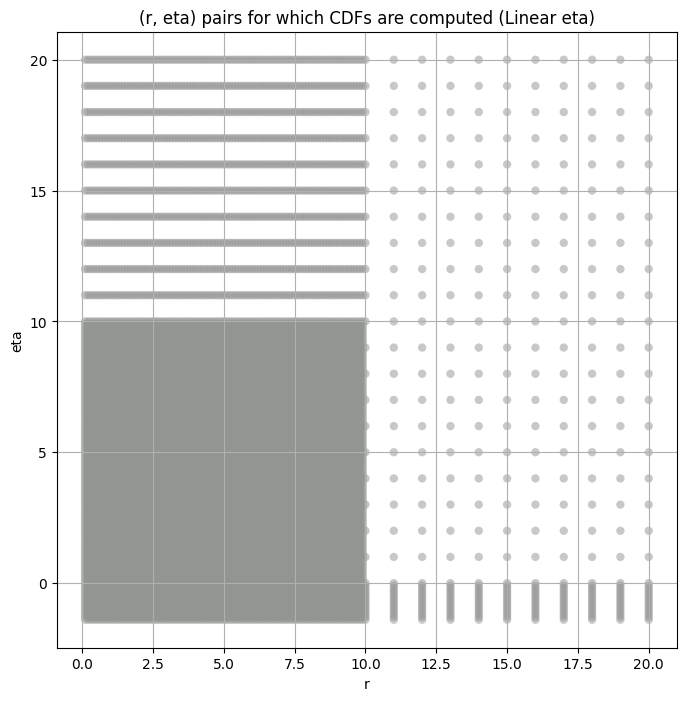

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1218.653100  1124.706900  1316.545000   0.285280    0.000113   
3       290.572480   276.590480   305.190730   1.557775    1.244772   
4        60.992805    57.123000    65.238610   4.609925    3.008300   
5        12.184865    11.295450    13.233427   7.296759    4.731154   
6         2.424221     2.213891     2.720137  13.013254    6.606739   
7         0.520145     0.466576     0.629550  29.398346    8.221189   
8         0.154834     0.136654     0.198347  47.283688    9.892746   
9         0.047433     0.041196     0.060780  54.099040   13.539720   

       kurt_upper  total_samples  
layer                             
2        0.616402         2446.0  
3        1.970670         9784.0  
4        8.811685        39136.0  
5       20.015156       156544.0  
6       51.278920       626176.0  
7      170.470540      2504704.0  
8      264.616520     10018816.0  
9      269.864140     40075264.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      1218.653100    1218.653076     1053.347900      945.853394   
3       290.572480     290.572479      270.625793      256.755432   
4        60.992805      60.992805       58.269272       56.641842   
5        12.184865      12.184865       11.833234       11.621486   
6         2.424221       2.424221        2.326873        2.275346   
7         0.520145       0.520145        0.491618        0.478991   
8         0.154834       0.154834        0.144538        0.140406   
9         0.047433       0.047433        0.043793        0.042277   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2          859.364136       785.603210       660.928589       558.528137   
3          245.269852       235.043716       217.332809       202.676147   
4           55.313419        54.158722        52.192909        50.463287   
5           11.444422        11.287972        11.011826        10.767020   
6            2.232455         2.194798         2.129937         2.073834   
7            0.468610         0.459629         0.444142         0.430854   
8            0.137031         0.134098         0.129064         0.124762   
9            0.041048         0.039986         0.038176         0.036643   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2           474.994049       402.084381       342.022644       209.130707  
3           189.756668       178.323730       168.055908       142.659668  
4            48.919197        47.517567        46.240604        42.841625  
5            10.545350        10.341555        10.152534         9.651870  
6             2.023521         1.977628         1.935256         1.823818  
7             0.419093         0.408421         0.398624         0.373106  
8             0.120957         0.117527         0.114387         0.106252  
9             0.035299         0.034096         0.033003         0.030204

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.01572764883567382 1218.6531


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.02736576270555069 1053.3479


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.038852122194953154 945.8534


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.048589612977929963 859.36414


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.05721802068268145 785.6032


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.07257040218694855 660.9286


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.09131823985647647 558.52814


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.1093550848242767 474.99405


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.1269567200044851 402.08438


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.14413544221603236 342.02264


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.18885835752972802 209.1307
Number of samples: 2446, Without approximation : 2446.0


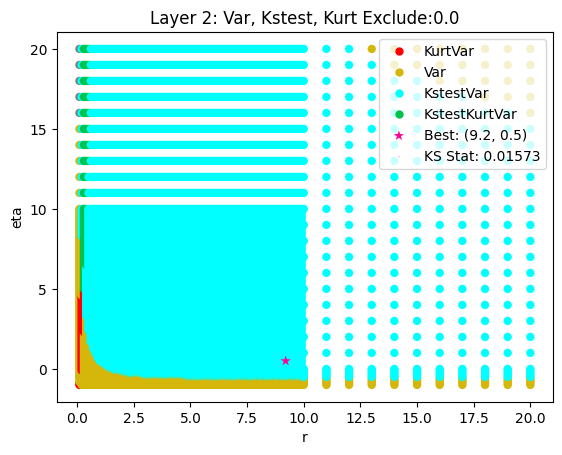

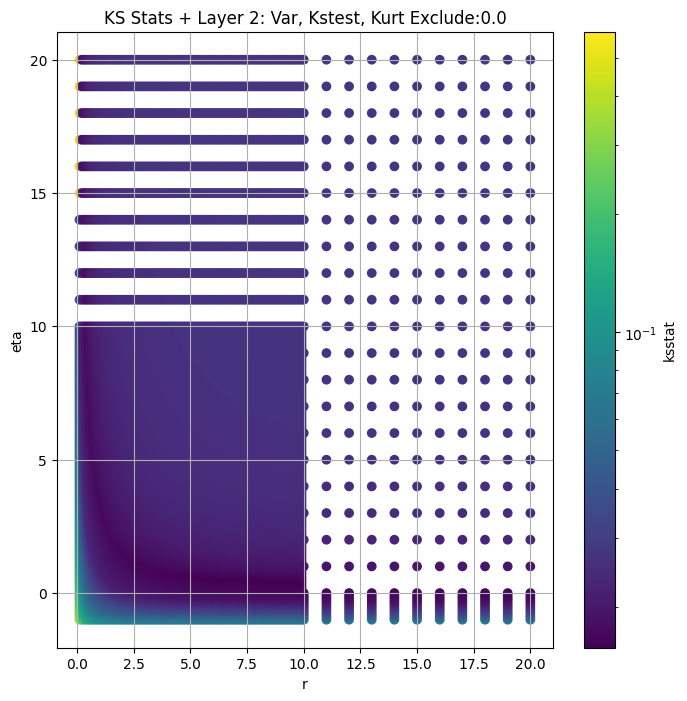

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.0071278632150255095 290.57248


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.00961363099084056 270.6258


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.01045362923330051 256.75543


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.013225571938016822 245.26985


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.016428289440937688 235.04372


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.022582048203217325 217.33281


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.02823656182094876 202.67615


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.03372498128775721 189.75667


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.03875748017816887 178.32373


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.043769563190171556 168.05591


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.057530090061661016 142.65967
Number of samples: 9784, Without approximation : 9784.0


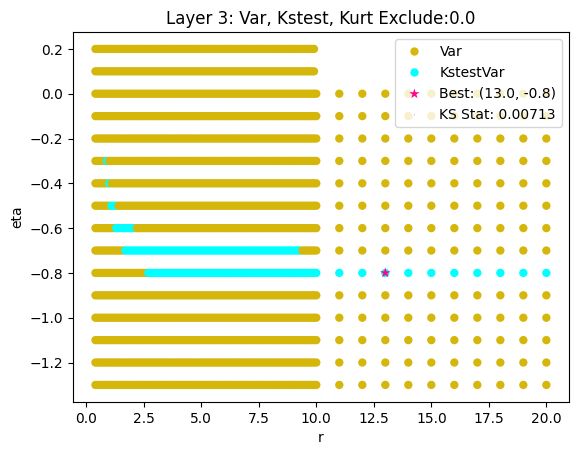

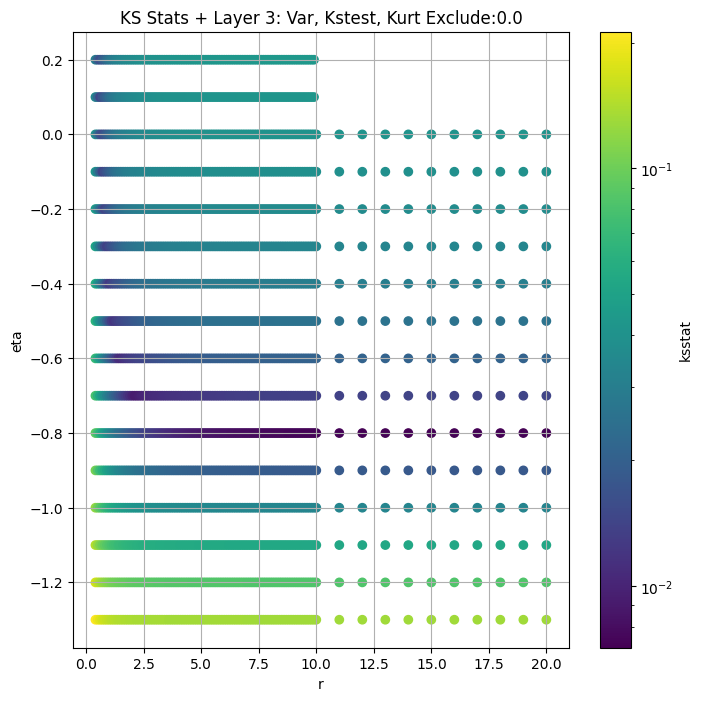

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.005520851571455654 60.992805


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.005772929691382378 58.26927


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.006049631168406844 56.64184


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.0061840781399287725 55.31342


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.0064348787515990935 54.158722


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.006967471836923367 52.19291


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.008521643739426321 50.463287


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.010583997302362813 48.919197


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.012764911711583449 47.517567


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.014466940265334516 46.240604


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.018743133810605328 42.841625
Number of samples: 39136, Without approximation : 39136.0


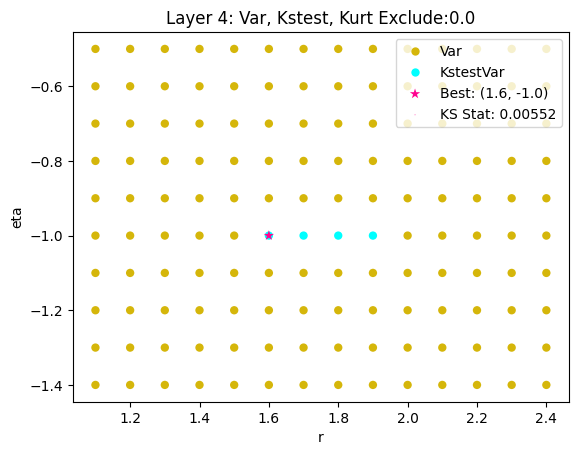

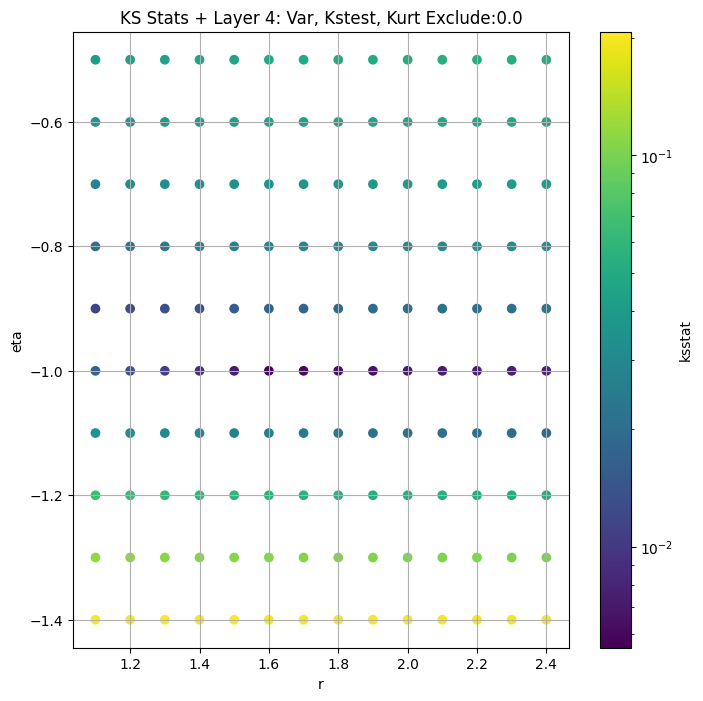

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.005401802652455934 12.184865


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.005280104427979437 11.833234


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.005126430007482252 11.621486


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.004998671809463562 11.444422


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.005032089860918659 11.287972


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.004906924900194065 11.011826


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.004925649668460652 10.76702


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.004877314860032733 10.54535


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.00548044741644671 10.341555


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.006095497154658555 10.152534


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.007734647286099114 9.65187
Number of samples: 100000, Without approximation : 156544.0


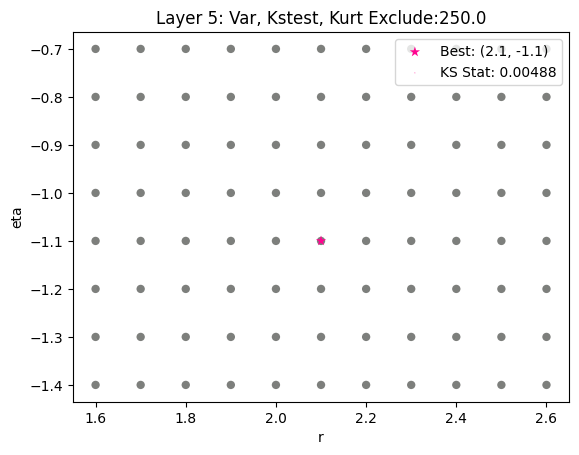

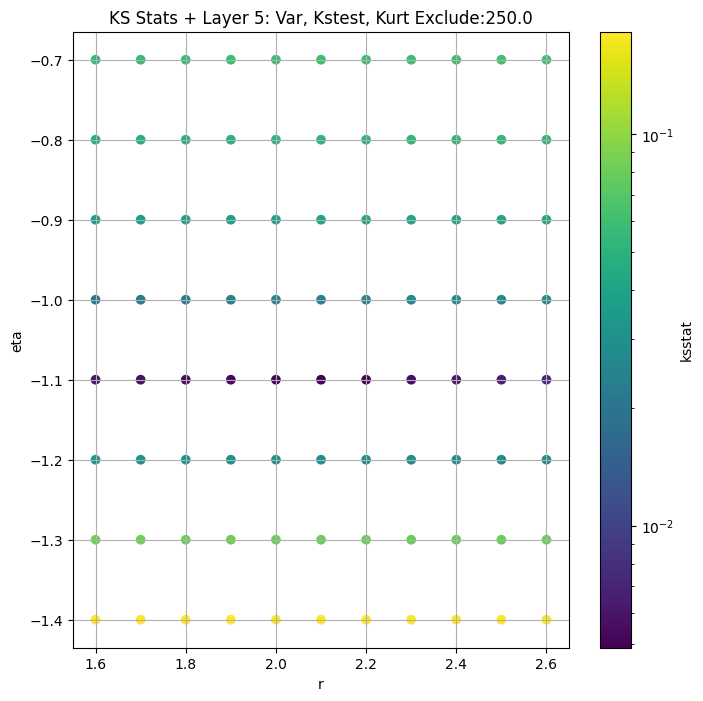

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.019098294702618812 2.424221


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.01878959527281676 2.326873


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.018619076375071764 2.275346


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.018473135591251078 2.2324555


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.018341868814705786 2.1947985


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.018334997623085325 2.1299374


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.0189923847774498 2.0738337


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.0191118490232709 2.0235214


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.018939442526693995 1.9776282


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.018775421558634986 1.9352564


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.01831998508435817 1.8238183
Number of samples: 100000, Without approximation : 626176.0


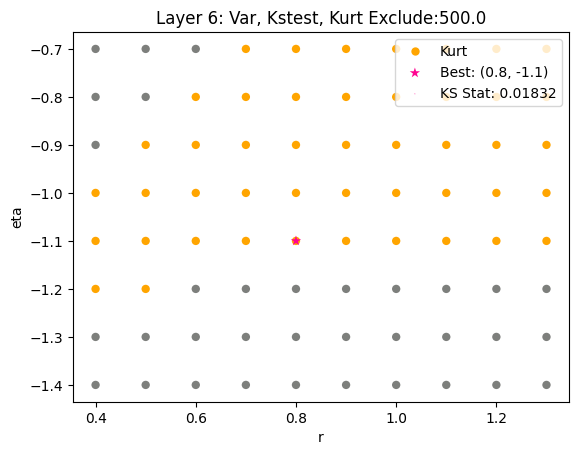

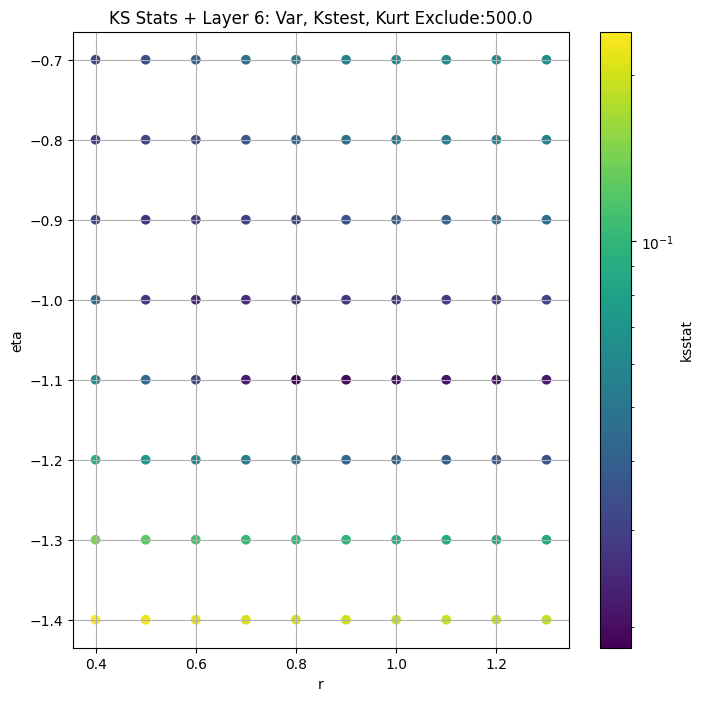

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.0242798362061305 0.52014524


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.023952625943825967 0.4916175


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.023576051485492022 0.47899118


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.02325690668912378 0.46860972


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.022973530493609062 0.459629


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.024076813482144077 0.44414178


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.02407630017818818 0.43085355


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.023675730475128665 0.41909307


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.02329971263422609 0.40842083


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.023488873061136006 0.39862356


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.023548003561590924 0.37310573
Number of samples: 100000, Without approximation : 2504704.0


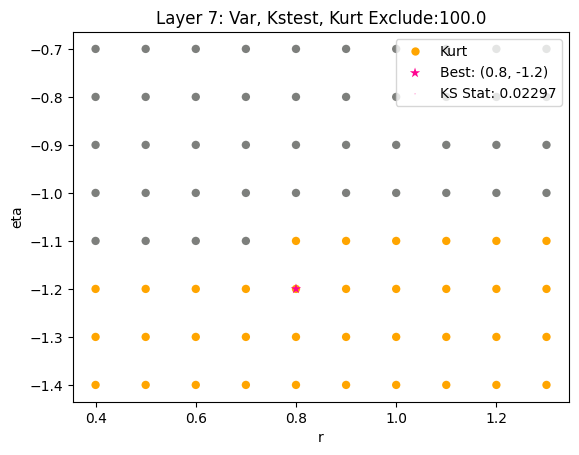

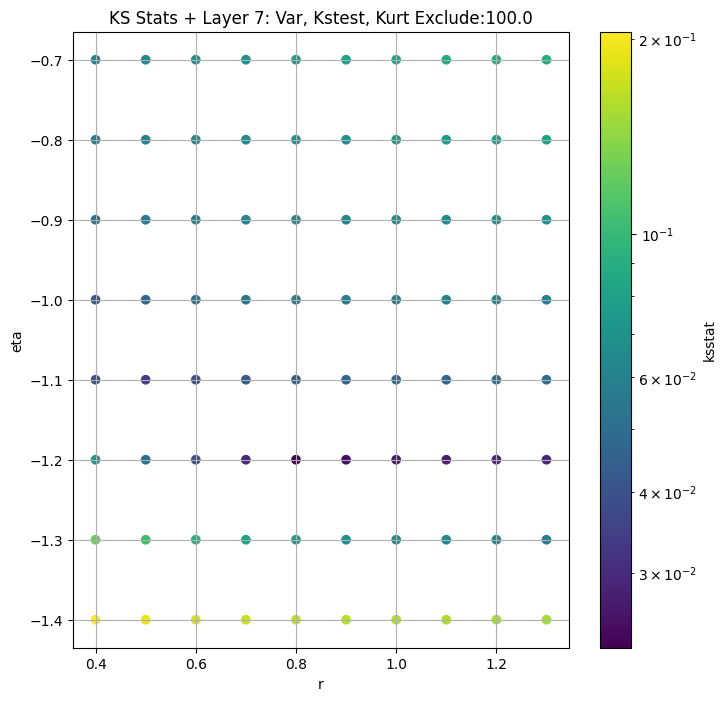

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.009266489122662369 0.15483391


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.00812394526745086 0.14453757


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.008288344851931528 0.14040557


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.00843017992501649 0.13703145


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.008295514145671201 0.13409802


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.008378283017524968 0.12906374


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.008563589960668971 0.12476157


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.008334704920396396 0.12095744


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.008282024923658815 0.11752704


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.008429755884120094 0.11438733


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.008721237657627778 0.10625172
Number of samples: 100000, Without approximation : 10018816.0


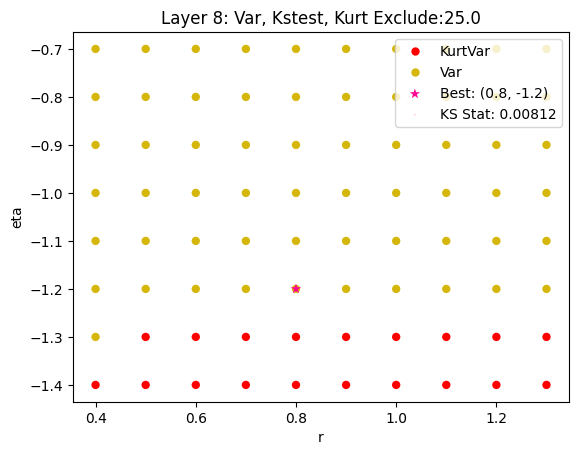

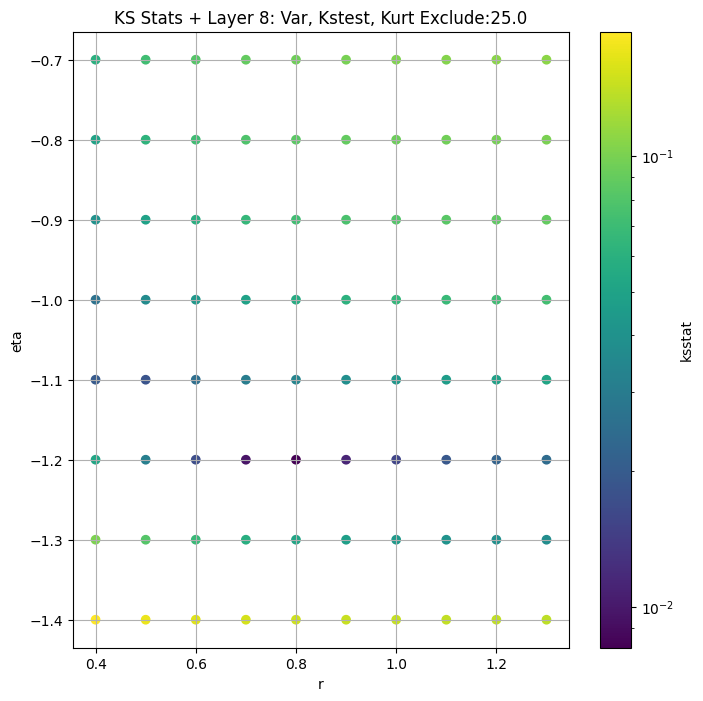

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.017232949343389703 0.047432758


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.01549390750133317 0.043793097


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.016904736899092998 0.042276997


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.01810209692432685 0.041048065


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.0191700486664369 0.03998629


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.021082919399813632 0.038176056


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.021711379038338197 0.03664328


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.020074234420173587 0.035299383


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.01916900267499877 0.03409568


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.019568571616722596 0.033002567


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.02069663564473323 0.030203564
Number of samples: 100000, Without approximation : 40075264.0


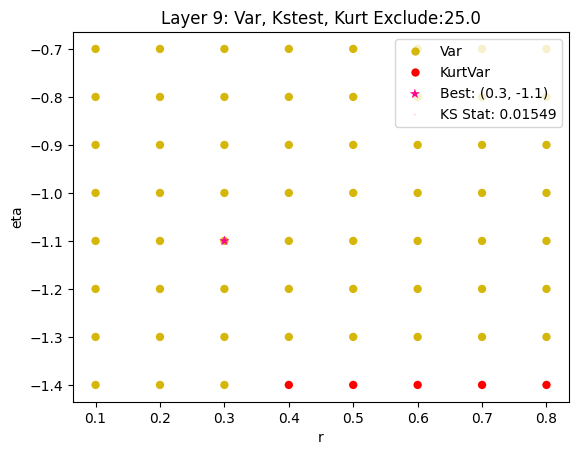

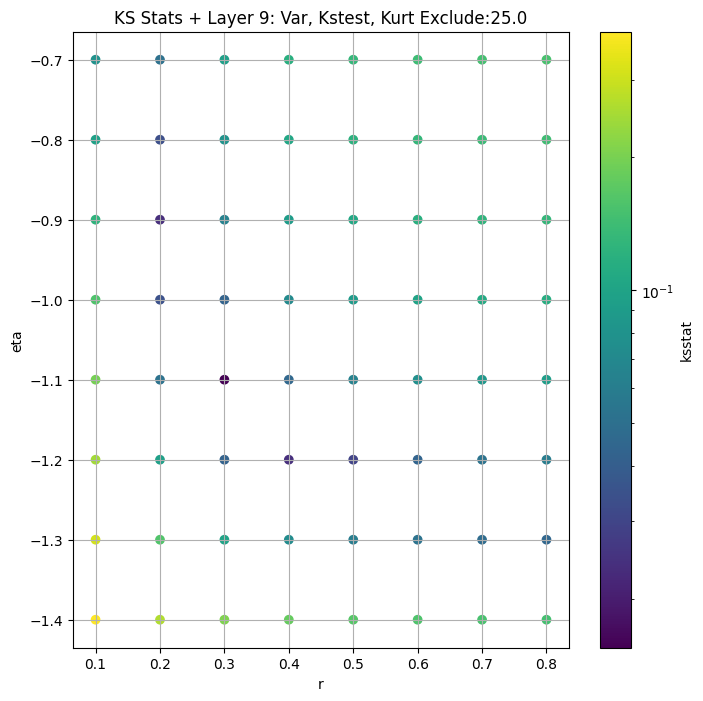

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1218.653100  1124.706900  1316.545000   0.285280    0.000113   
3       290.572480   276.590480   305.190730   1.557775    1.244772   
4        60.992805    57.123000    65.238610   4.609925    3.008300   
5        12.184865    11.295450    13.233427   7.296759    4.731154   
6         2.424221     2.213891     2.720137  13.013254    6.606739   
7         0.520145     0.466576     0.629550  29.398346    8.221189   
8         0.154834     0.136654     0.198347  47.283688    9.892746   
9         0.047433     0.041196     0.060780  54.099040   13.539720   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.616402         2446.0             0.015728        9.2          0.5   
3        1.970670         9784.0             0.007128       13.0         -0.8   
4        8.811685        39136.0             0.005521        1.6         -1.0   
5       20.015156       156544.0             0.004877        2.1         -1.1   
6       51.278920       626176.0             0.018320        0.8         -1.1   
7      170.470540      2504704.0             0.022974        0.8         -1.2   
8      264.616520     10018816.0             0.008124        0.8         -1.2   
9      269.864140     40075264.0             0.015494        0.3         -1.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        1868.632480                     0.0         1218.653100   
3         729.705577                     0.0          290.572480   
4         168.058873                     0.0           60.992805   
5          37.644964                   250.0           10.545350   
6           3.517317                   500.0            1.823818   
7           1.215205                   100.0            0.459629   
8           0.382140                    25.0            0.144538   
9           0.002658                    25.0            0.043793   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.027391  
3                     0.013713  
4                     0.006861  
5                     0.003431  
6                     0.001716  
7                     0.000858  
8                     0.000429  
9                     0.000215

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.057638699353230405, var: 785.6032104492188


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.04964952725490979, var: 859.3641357421875


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.04063133791807827, var: 945.8533935546875


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.02998140913695302, var: 1053.347900390625


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.01572764883567382, var: 1218.653076171875
Number of samples: 2446, Without approximation : 2446.0


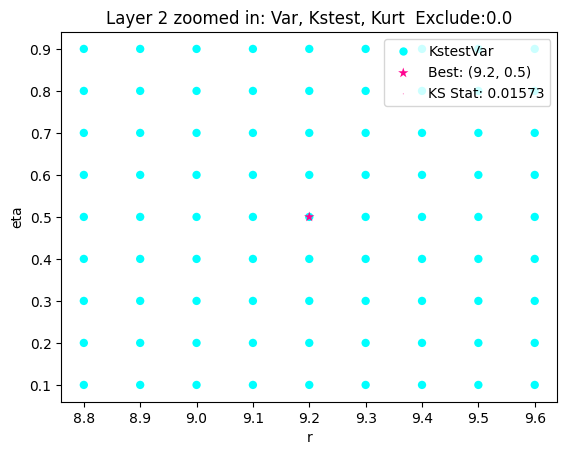

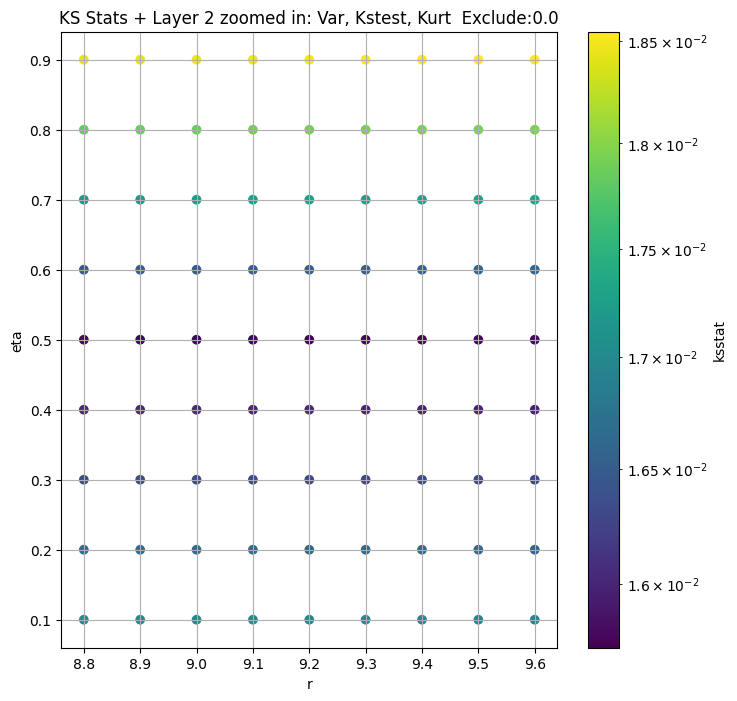

Layer 3


  0%|          | 0/9 [00:00<?, ?it/s]

Finding Minimum after computing 9 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.01650968784571273, var: 235.04371643066406


  0%|          | 0/9 [00:00<?, ?it/s]

Finding Minimum after computing 9 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.013323668785518758, var: 245.2698516845703


  0%|          | 0/9 [00:00<?, ?it/s]

Finding Minimum after computing 9 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.010674895500684012, var: 256.75543212890625


  0%|          | 0/9 [00:00<?, ?it/s]

Finding Minimum after computing 9 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.011171317608547837, var: 270.62579345703125


  0%|          | 0/9 [00:00<?, ?it/s]

Finding Minimum after computing 9 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.0071278632150255095, var: 290.5724792480469
Number of samples: 9784, Without approximation : 9784.0


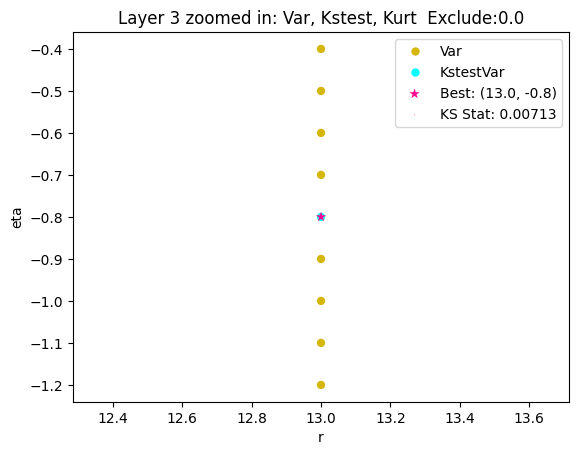

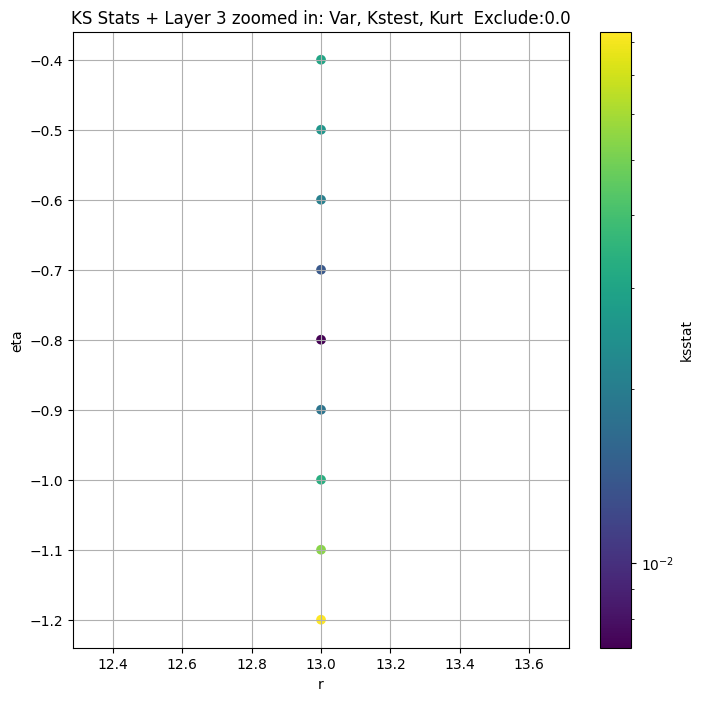

Layer 4


  0%|          | 0/1584 [00:00<?, ?it/s]

Finding Minimum after computing 1584 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.008331447681301896, var: 54.158721923828125


  0%|          | 0/1584 [00:00<?, ?it/s]

Finding Minimum after computing 1584 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.007393638395338853, var: 55.313419342041016


  0%|          | 0/1584 [00:00<?, ?it/s]

Finding Minimum after computing 1584 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.006712227952825334, var: 56.641841888427734


  0%|          | 0/1584 [00:00<?, ?it/s]

Finding Minimum after computing 1584 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.005733008681396479, var: 58.26927185058594


  0%|          | 0/1584 [00:00<?, ?it/s]

Finding Minimum after computing 1584 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.004623094746009859, var: 60.99280548095703
Number of samples: 39136, Without approximation : 39136.0


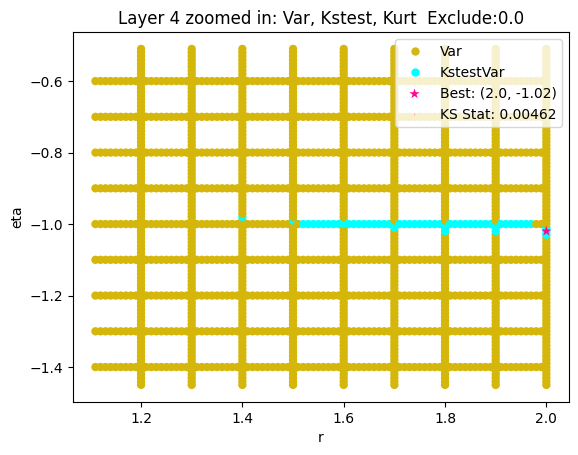

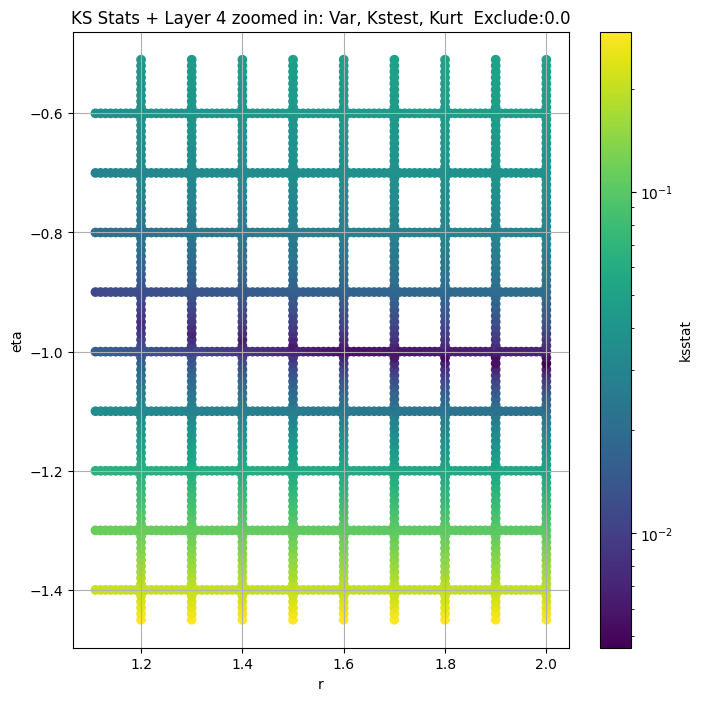

Layer 5


  0%|          | 0/668 [00:00<?, ?it/s]

Finding Minimum after computing 668 CDFs
layer 5, 250.0 + 100 = 350, ksstat: 0.006245073047735583, var: 10.152533531188965


  0%|          | 0/668 [00:00<?, ?it/s]

Finding Minimum after computing 668 CDFs
layer 5, 250.0 + 75 = 325, ksstat: 0.00584800047273927, var: 10.245348930358887


  0%|          | 0/668 [00:00<?, ?it/s]

Finding Minimum after computing 668 CDFs
layer 5, 250.0 + 50 = 300, ksstat: 0.00548044741644671, var: 10.341554641723633


  0%|          | 0/668 [00:00<?, ?it/s]

Finding Minimum after computing 668 CDFs
layer 5, 250.0 + 25 = 275, ksstat: 0.005165945637122228, var: 10.441286087036133


  0%|          | 0/668 [00:00<?, ?it/s]

Finding Minimum after computing 668 CDFs
layer 5, 250.0 + 0 = 250, ksstat: 0.004877314860032733, var: 10.545350074768066


  0%|          | 0/668 [00:00<?, ?it/s]

Finding Minimum after computing 668 CDFs
layer 5, 250.0 + -25 = 225, ksstat: 0.004871423377705186, var: 10.653358459472656


  0%|          | 0/668 [00:00<?, ?it/s]

Finding Minimum after computing 668 CDFs
layer 5, 250.0 + -50 = 200, ksstat: 0.004593640013892508, var: 10.767020225524902


  0%|          | 0/668 [00:00<?, ?it/s]

Finding Minimum after computing 668 CDFs
layer 5, 250.0 + -75 = 175, ksstat: 0.004776326231084371, var: 10.886126518249512


  0%|          | 0/668 [00:00<?, ?it/s]

Finding Minimum after computing 668 CDFs
layer 5, 250.0 + -100 = 150, ksstat: 0.0048625143106816315, var: 11.011825561523438
Number of samples: 100000, Without approximation : 156544.0


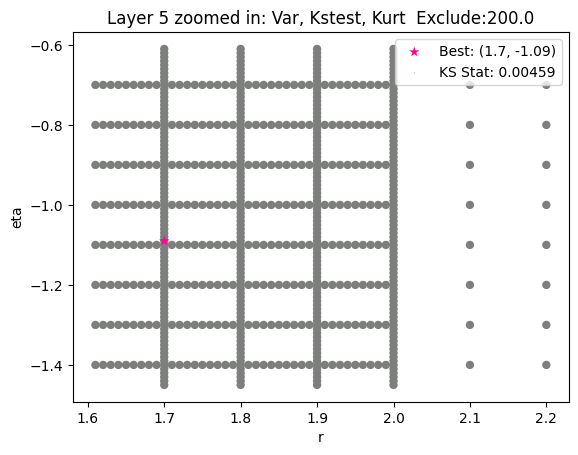

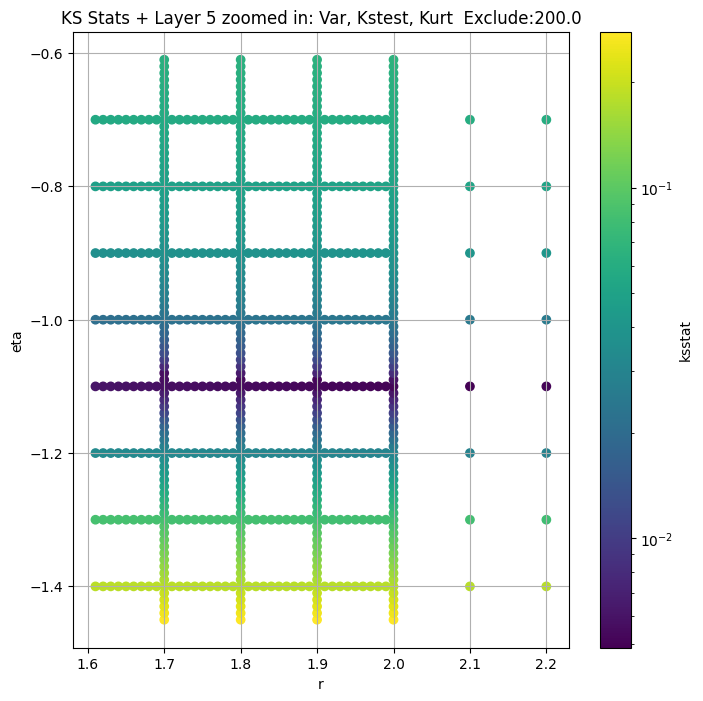

Layer 6


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 500.0 + 100 = 600, ksstat: 0.01740936989814512, var: 1.759251356124878


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 500.0 + 75 = 575, ksstat: 0.01747676849770763, var: 1.7747834920883179


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 500.0 + 50 = 550, ksstat: 0.01754501469282621, var: 1.7907007932662964


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 500.0 + 25 = 525, ksstat: 0.017614209419641647, var: 1.8070374727249146


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 500.0 + 0 = 500, ksstat: 0.017684407838443494, var: 1.823818325996399


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 500.0 + -25 = 475, ksstat: 0.017595669297836403, var: 1.841062068939209


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 500.0 + -50 = 450, ksstat: 0.017370150687609887, var: 1.8587952852249146


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 500.0 + -75 = 425, ksstat: 0.01739219026526828, var: 1.877048373222351


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 500.0 + -100 = 400, ksstat: 0.01746852372109664, var: 1.8958373069763184
Number of samples: 100000, Without approximation : 626176.0


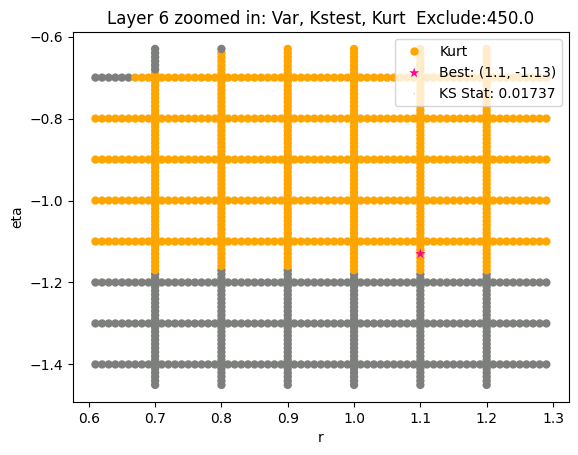

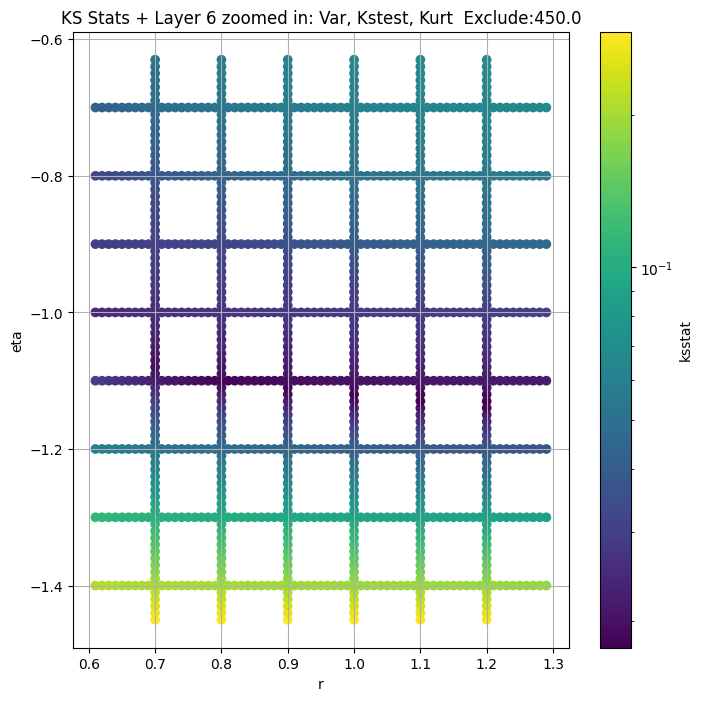

Layer 7


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 100.0 + 100 = 200, ksstat: 0.021638101903342977, var: 0.43085354566574097


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 100.0 + 75 = 175, ksstat: 0.021333083188284974, var: 0.43727627396583557


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 100.0 + 50 = 150, ksstat: 0.021100456943284607, var: 0.44414177536964417


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 100.0 + 25 = 125, ksstat: 0.021338931903856717, var: 0.4515528678894043


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 100.0 + 0 = 100, ksstat: 0.021554130965332097, var: 0.45962899923324585


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 100.0 + -25 = 75, ksstat: 0.02082855070787437, var: 0.4686097204685211


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 100.0 + -50 = 50, ksstat: 0.02001018247388764, var: 0.47899118065834045


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 100.0 + -75 = 25, ksstat: 0.02014125627014307, var: 0.49161750078201294


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 100.0 + -100 = 0, ksstat: 0.01997562949235826, var: 0.5201452374458313
Number of samples: 100000, Without approximation : 2504704.0


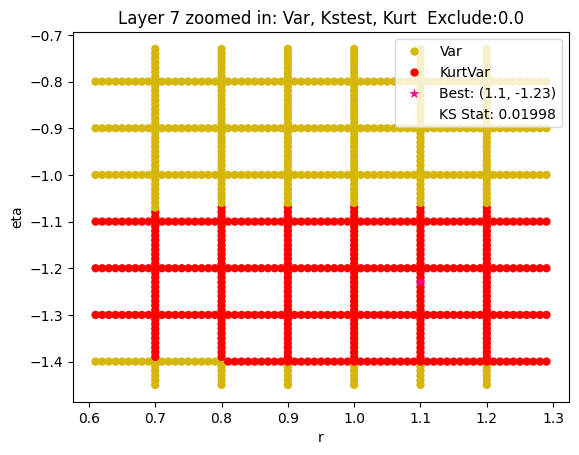

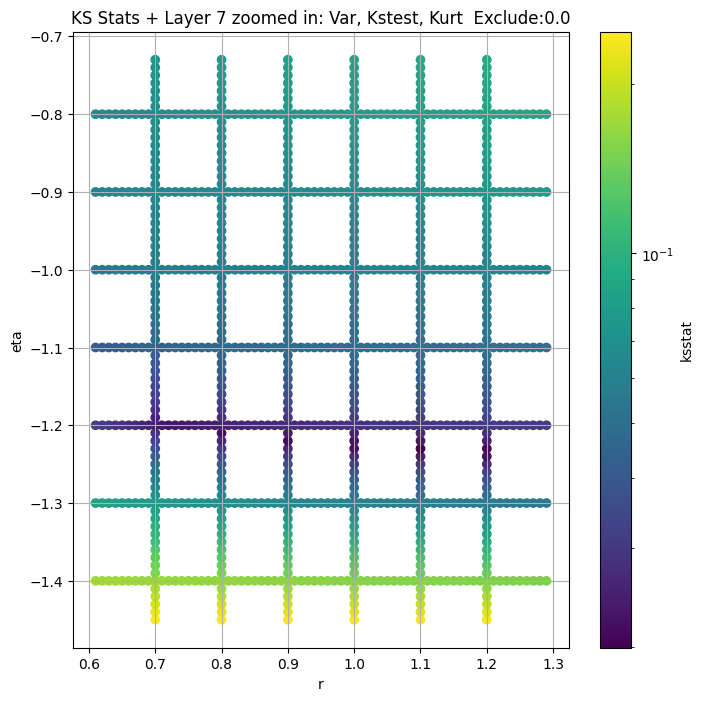

Layer 8


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 8, 25.0 + 100 = 125, ksstat: 0.00790318921901012, var: 0.13146597146987915


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 8, 25.0 + 75 = 100, ksstat: 0.007888400920300631, var: 0.13409802317619324


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 8, 25.0 + 50 = 75, ksstat: 0.0079181173423577, var: 0.1370314508676529


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 8, 25.0 + 25 = 50, ksstat: 0.007415284016065282, var: 0.1404055655002594


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 8, 25.0 + 0 = 25, ksstat: 0.007753627429520127, var: 0.1445375680923462


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 8, 25.0 + -25 = 0, ksstat: 0.007549076389129605, var: 0.15483391284942627
Number of samples: 100000, Without approximation : 10018816.0


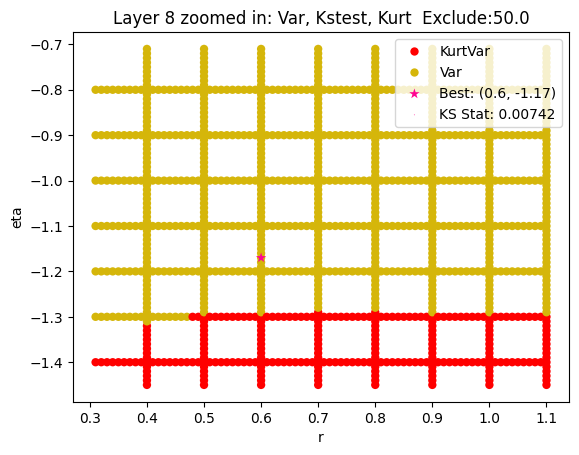

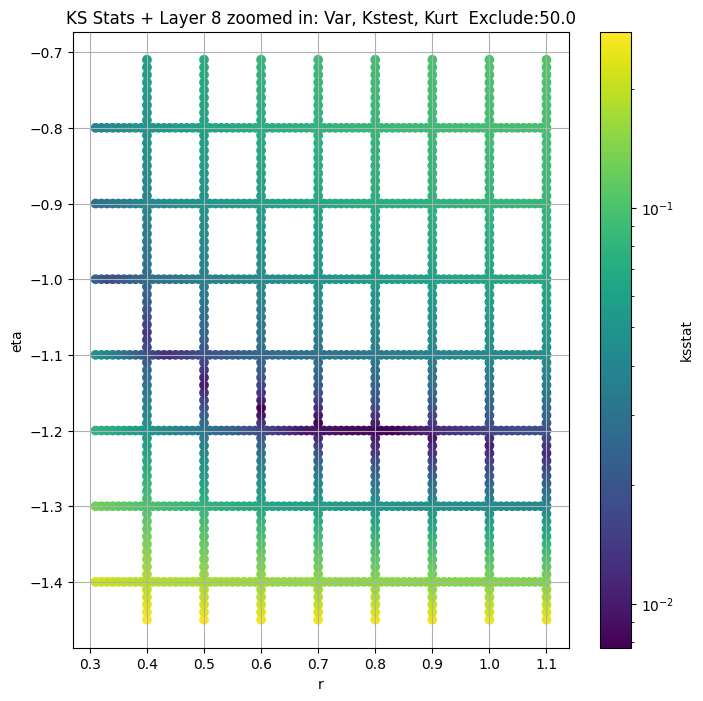

Layer 9


  0%|          | 0/1163 [00:00<?, ?it/s]

Finding Minimum after computing 1163 CDFs
layer 9, 25.0 + 100 = 125, ksstat: 0.016618936290900832, var: 0.03903820738196373


  0%|          | 0/1163 [00:00<?, ?it/s]

Finding Minimum after computing 1163 CDFs
layer 9, 25.0 + 75 = 100, ksstat: 0.017179527785065374, var: 0.03998629003763199


  0%|          | 0/1163 [00:00<?, ?it/s]

Finding Minimum after computing 1163 CDFs
layer 9, 25.0 + 50 = 75, ksstat: 0.016274494453187516, var: 0.041048064827919006


  0%|          | 0/1163 [00:00<?, ?it/s]

Finding Minimum after computing 1163 CDFs
layer 9, 25.0 + 25 = 50, ksstat: 0.015945090512583193, var: 0.04227699711918831


  0%|          | 0/1163 [00:00<?, ?it/s]

Finding Minimum after computing 1163 CDFs
layer 9, 25.0 + 0 = 25, ksstat: 0.01549390750133317, var: 0.043793097138404846


  0%|          | 0/1163 [00:00<?, ?it/s]

Finding Minimum after computing 1163 CDFs
layer 9, 25.0 + -25 = 0, ksstat: 0.014079003627434417, var: 0.047432757914066315
Number of samples: 100000, Without approximation : 40075264.0


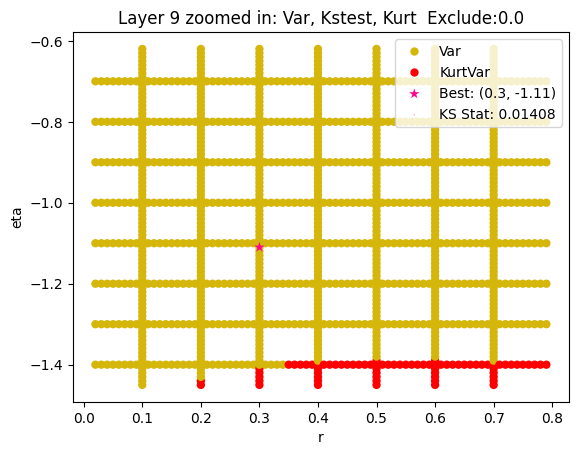

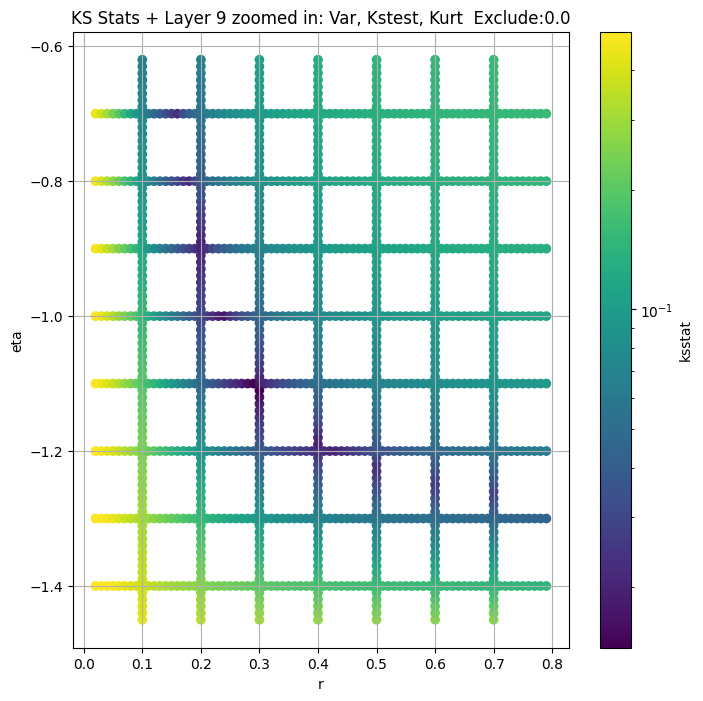

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1218.653100  1124.706900  1316.545000   0.285280    0.000113   
3       290.572480   276.590480   305.190730   1.557775    1.244772   
4        60.992805    57.123000    65.238610   4.609925    3.008300   
5        12.184865    11.295450    13.233427   7.296759    4.731154   
6         2.424221     2.213891     2.720137  13.013254    6.606739   
7         0.520145     0.466576     0.629550  29.398346    8.221189   
8         0.154834     0.136654     0.198347  47.283688    9.892746   
9         0.047433     0.041196     0.060780  54.099040   13.539720   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.616402         2446.0             0.015728        9.2          0.5   
3        1.970670         9784.0             0.007128       13.0         -0.8   
4        8.811685        39136.0             0.005521        1.6         -1.0   
5       20.015156       156544.0             0.004877        2.1         -1.1   
6       51.278920       626176.0             0.018320        0.8         -1.1   
7      170.470540      2504704.0             0.022974        0.8         -1.2   
8      264.616520     10018816.0             0.008124        0.8         -1.2   
9      269.864140     40075264.0             0.015494        0.3         -1.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        1868.632480                     0.0         1218.653100   
3         729.705577                     0.0          290.572480   
4         168.058873                     0.0           60.992805   
5          37.644964                   250.0           10.767020   
6           3.517317                   500.0            1.858795   
7           1.215205                   100.0            0.520145   
8           0.382140                    25.0            0.140406   
9           0.002658                    25.0            0.047433   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.027391          0.015728     9.2      0.50   
3                     0.013713          0.007128    13.0     -0.80   
4                     0.006861          0.004623     2.0     -1.02   
5                     0.003431          0.004594     1.7     -1.09   
6                     0.001716          0.017370     1.1     -1.13   
7                     0.000858          0.019976     1.1     -1.23   
8                     0.000429          0.007415     0.6     -1.17   
9                     0.000215          0.014079     0.3     -1.11   

        best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                 
2      1868.632480                  0.0         7833  
3       729.705577                  0.0        37147  
4       186.357619                  0.0        88056  
5        35.796234                200.0        88056  
6         5.436470                450.0         6190  
7         2.064057                  0.0         4641  
8         0.204071                 50.0        33021  
9         0.003034                  0.0         9784

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

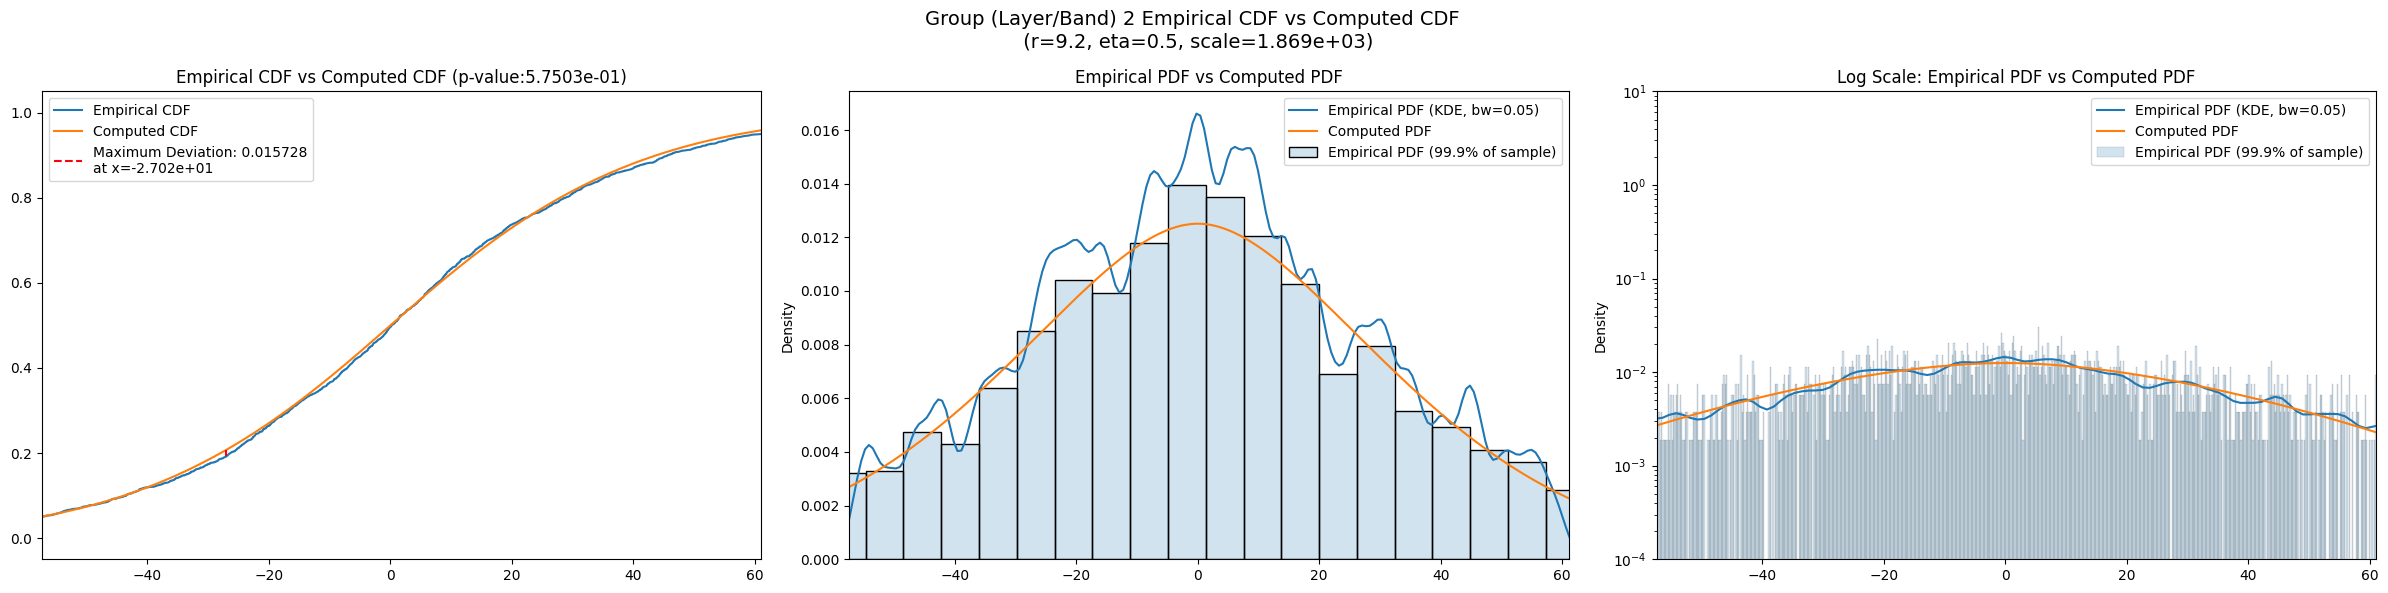

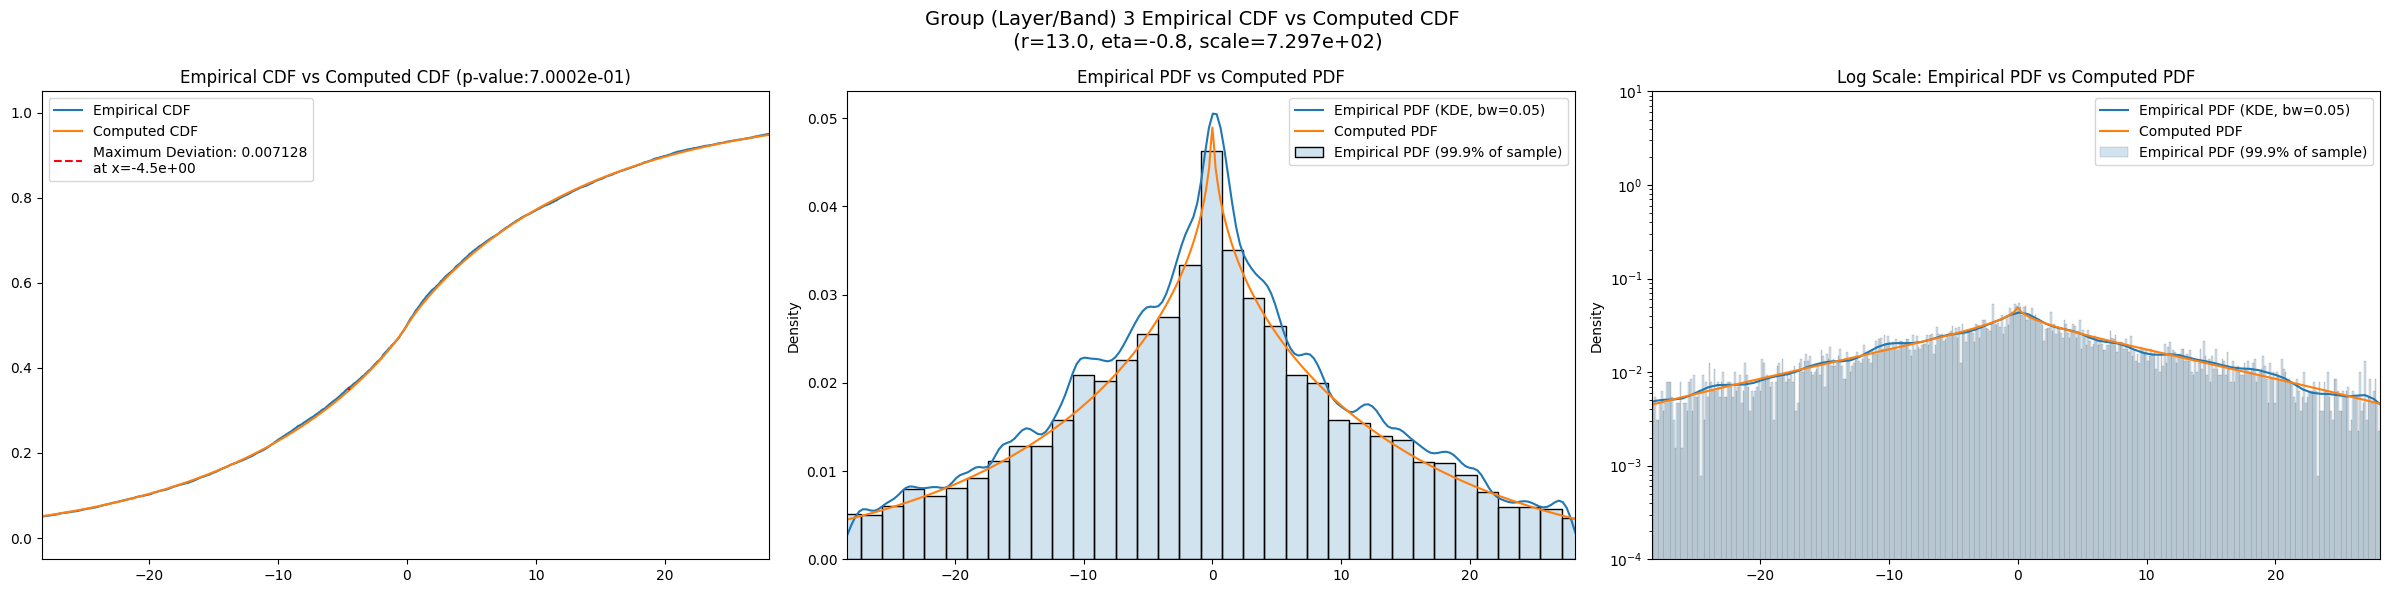

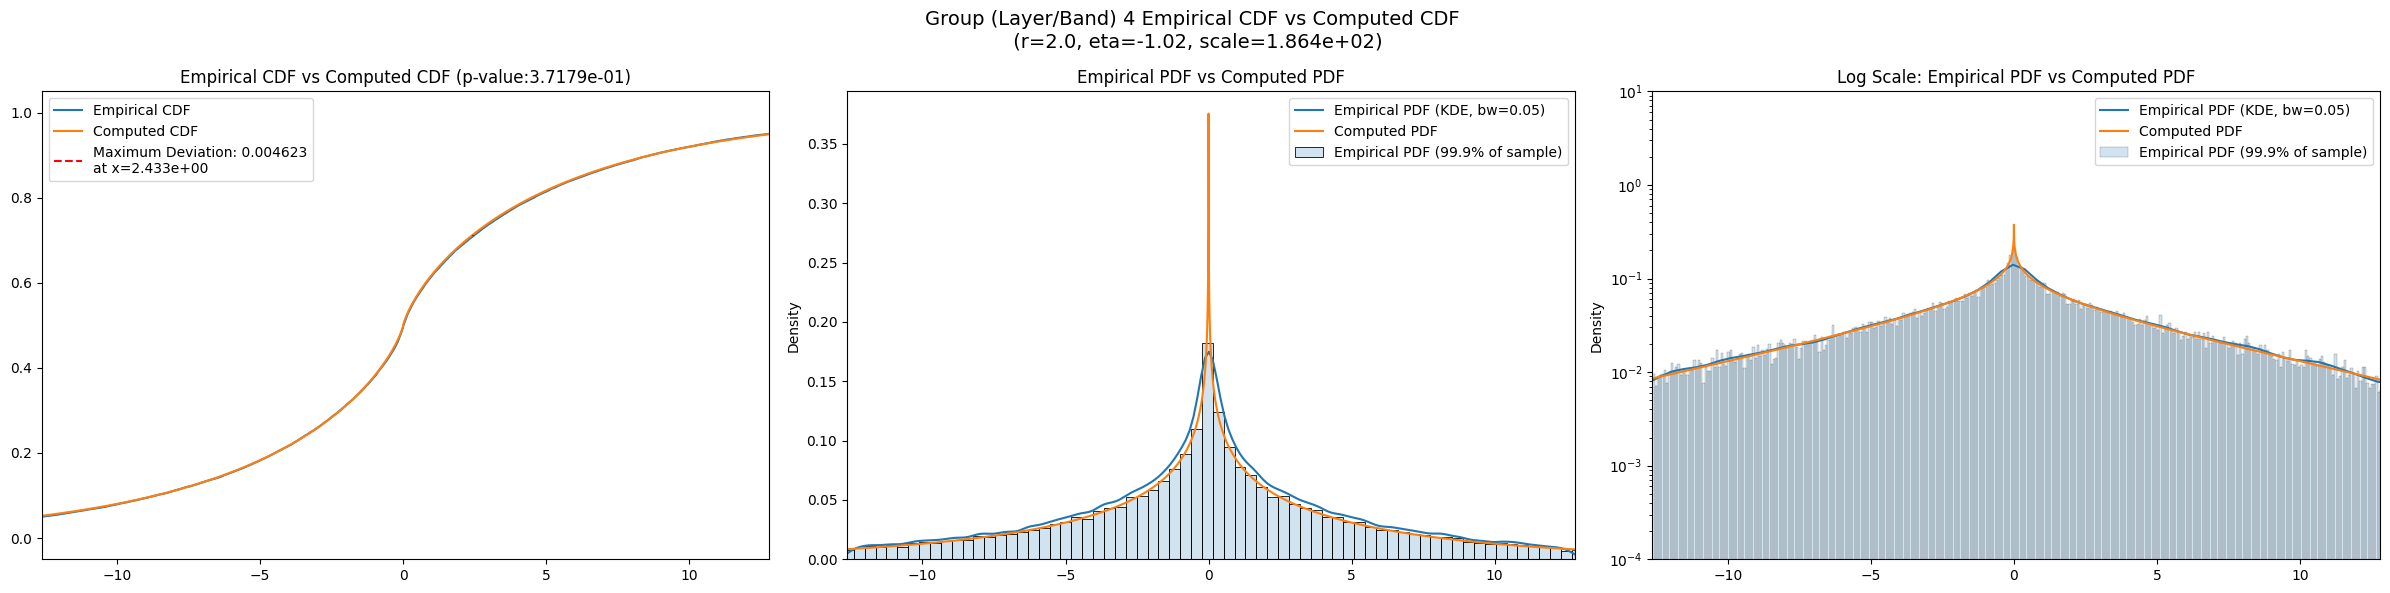

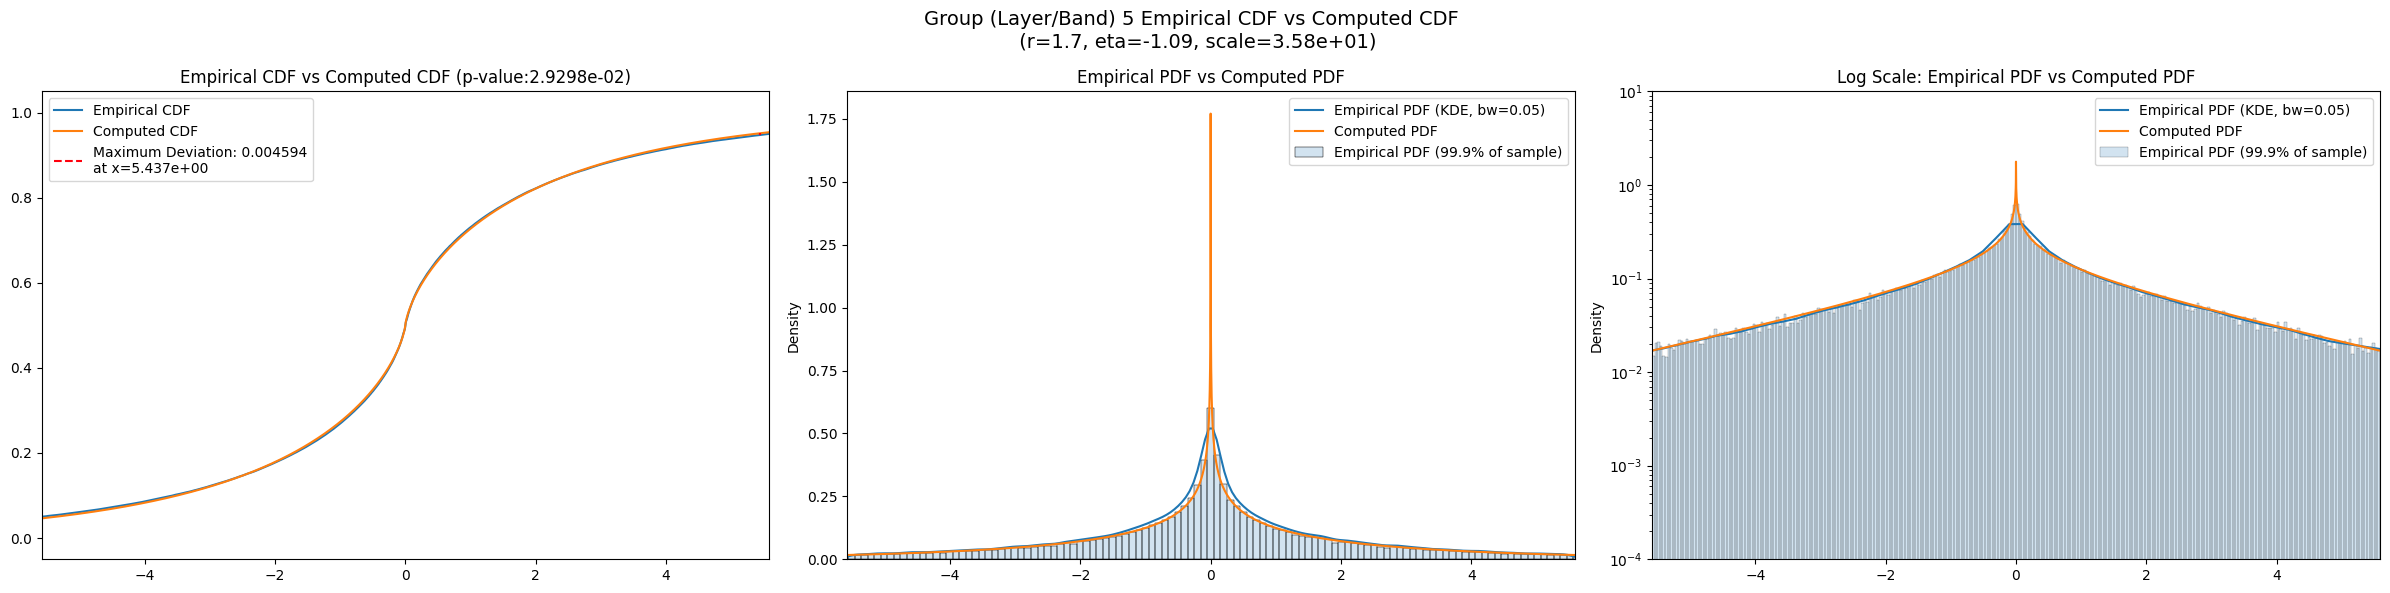

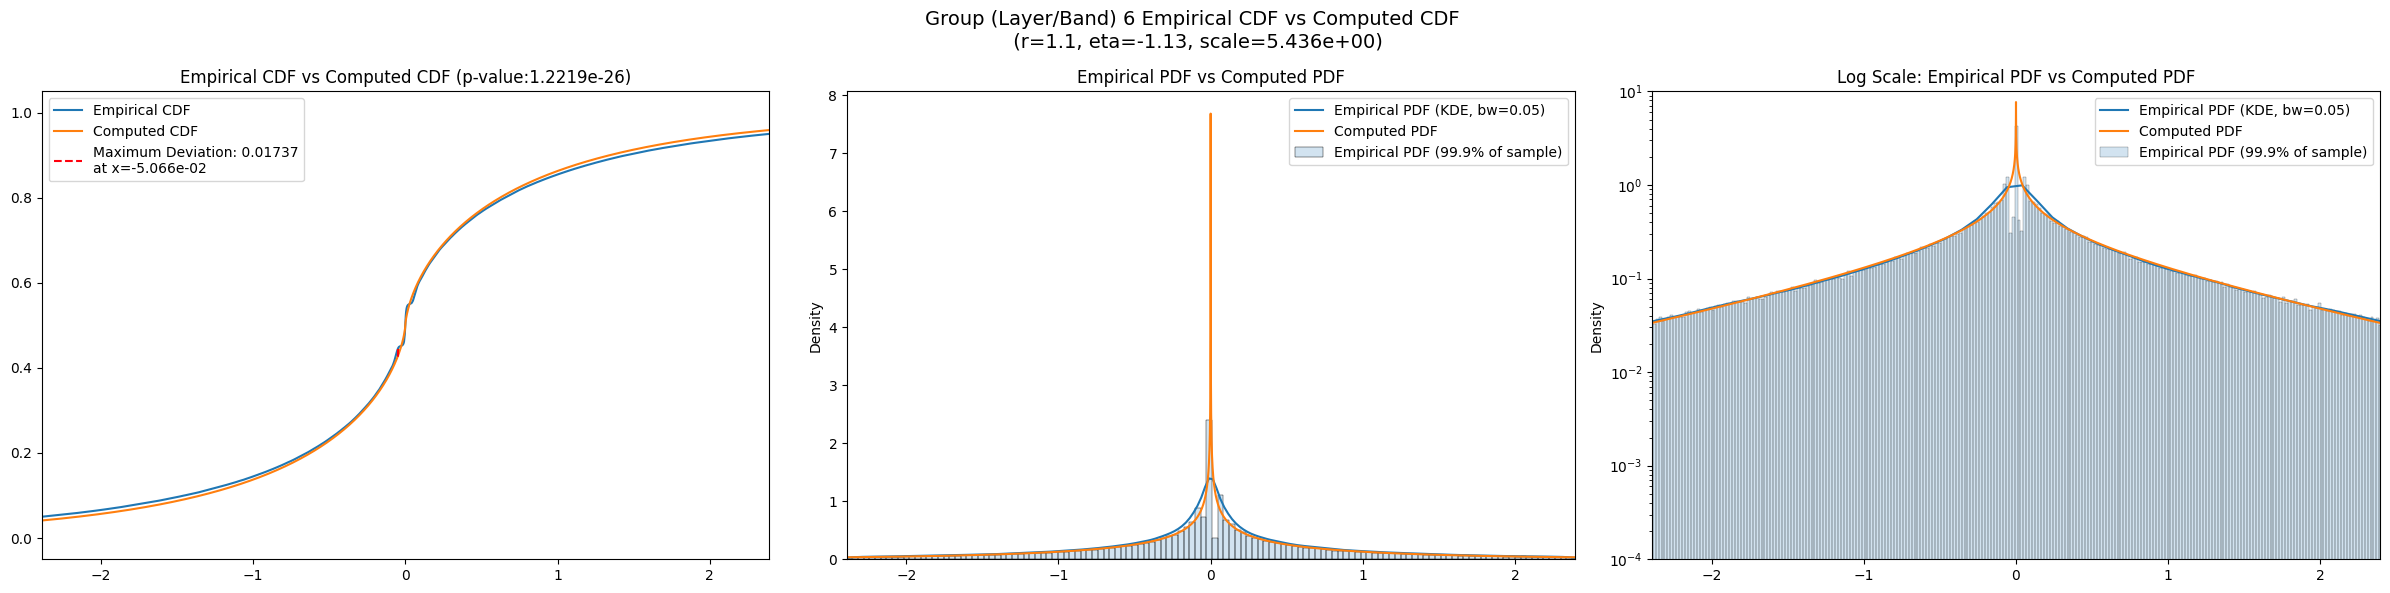

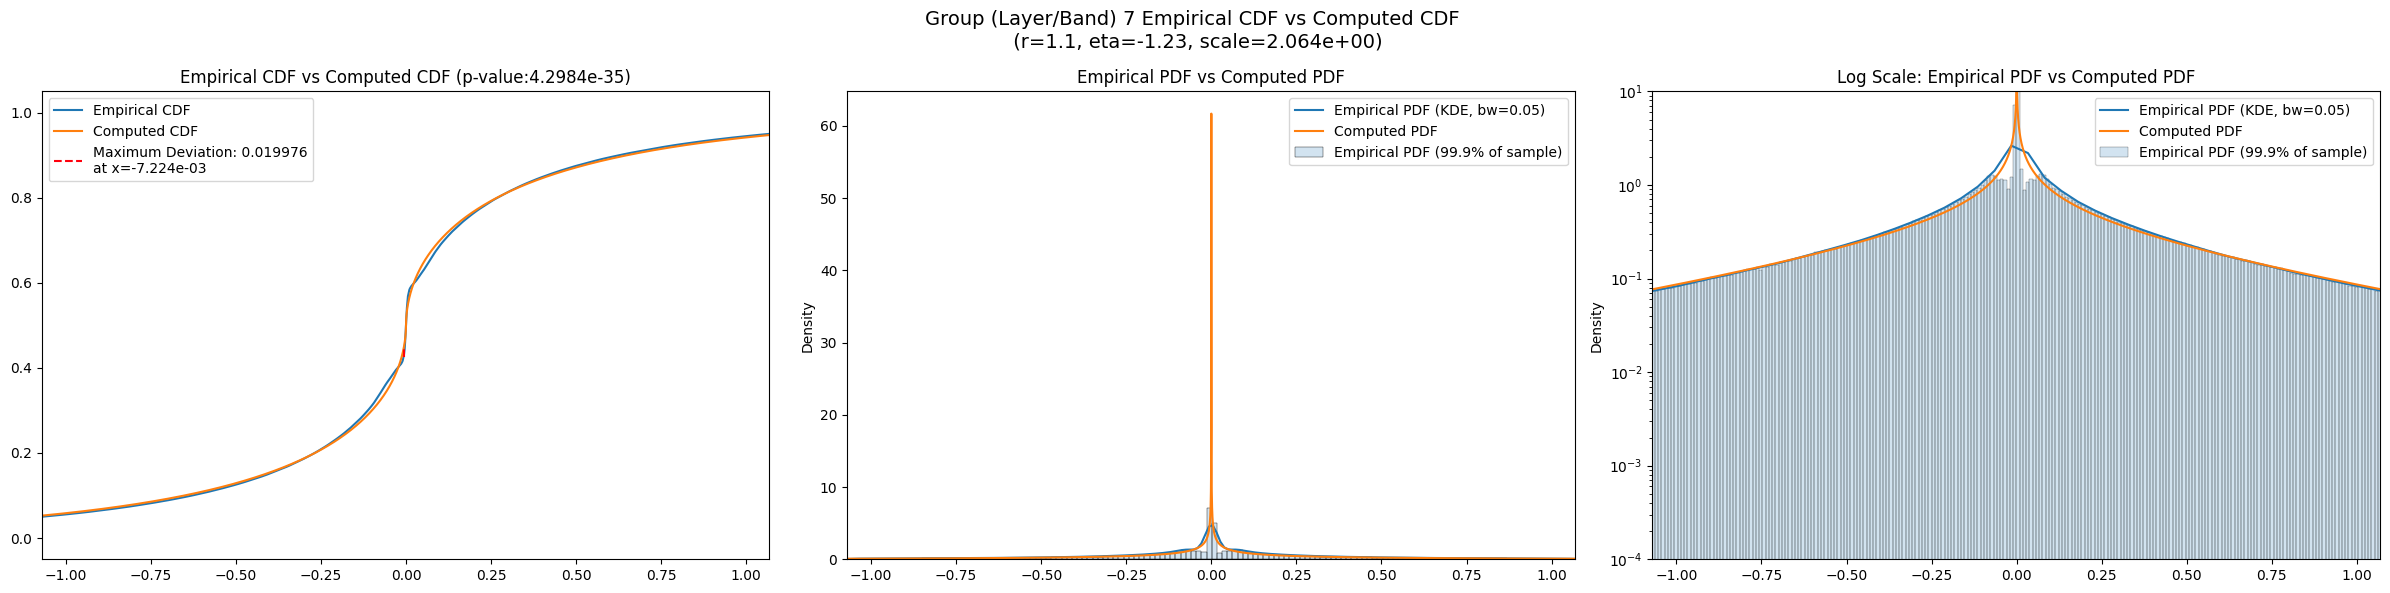

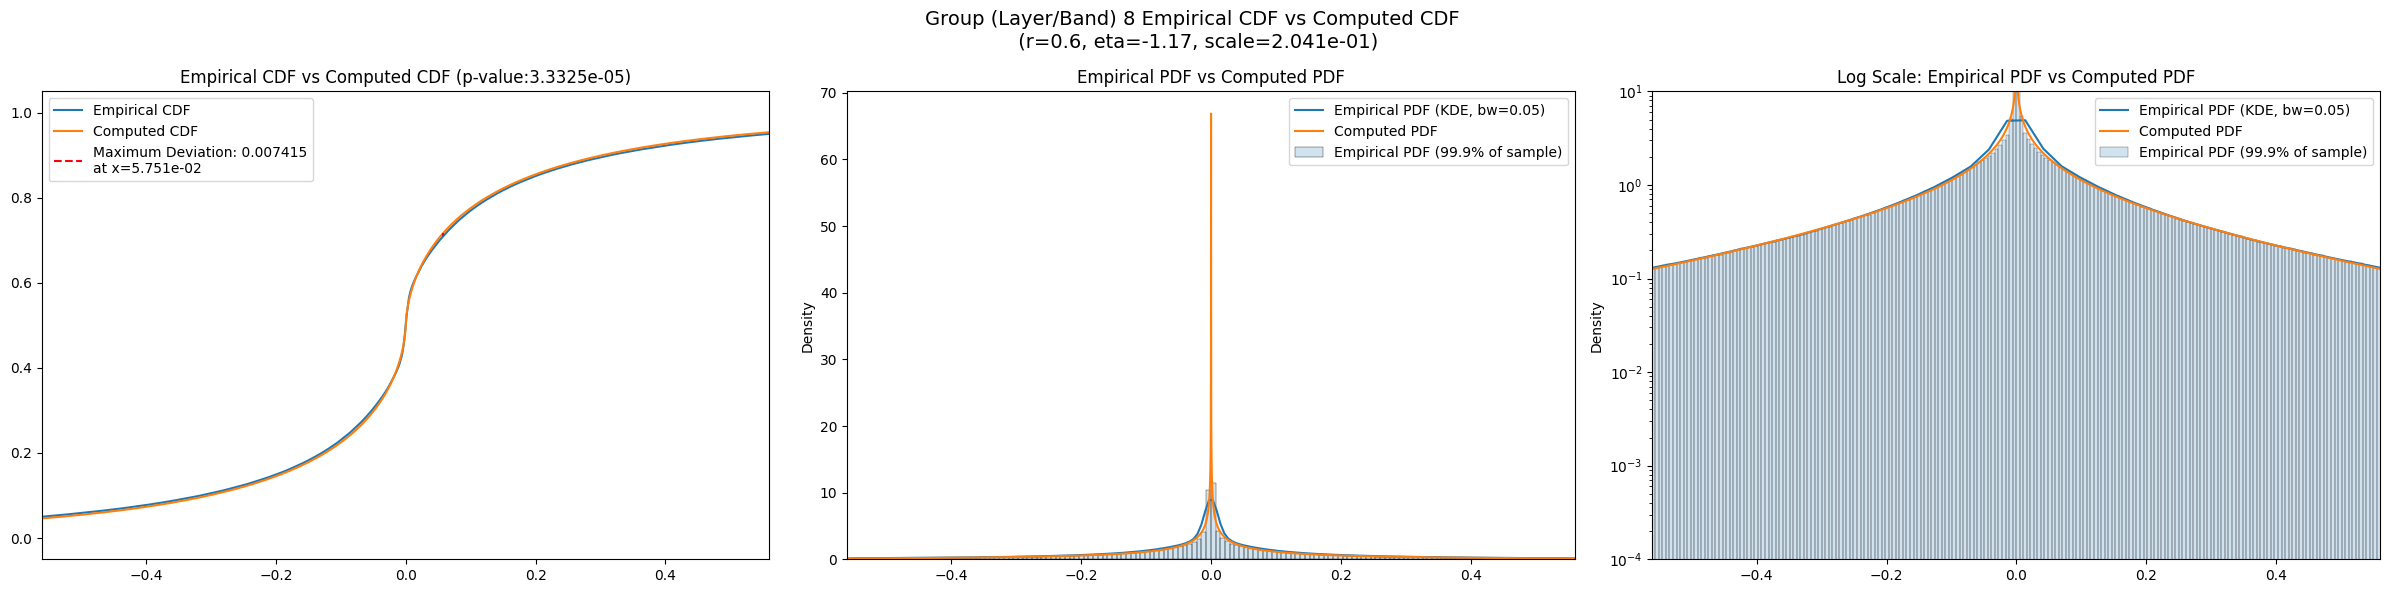

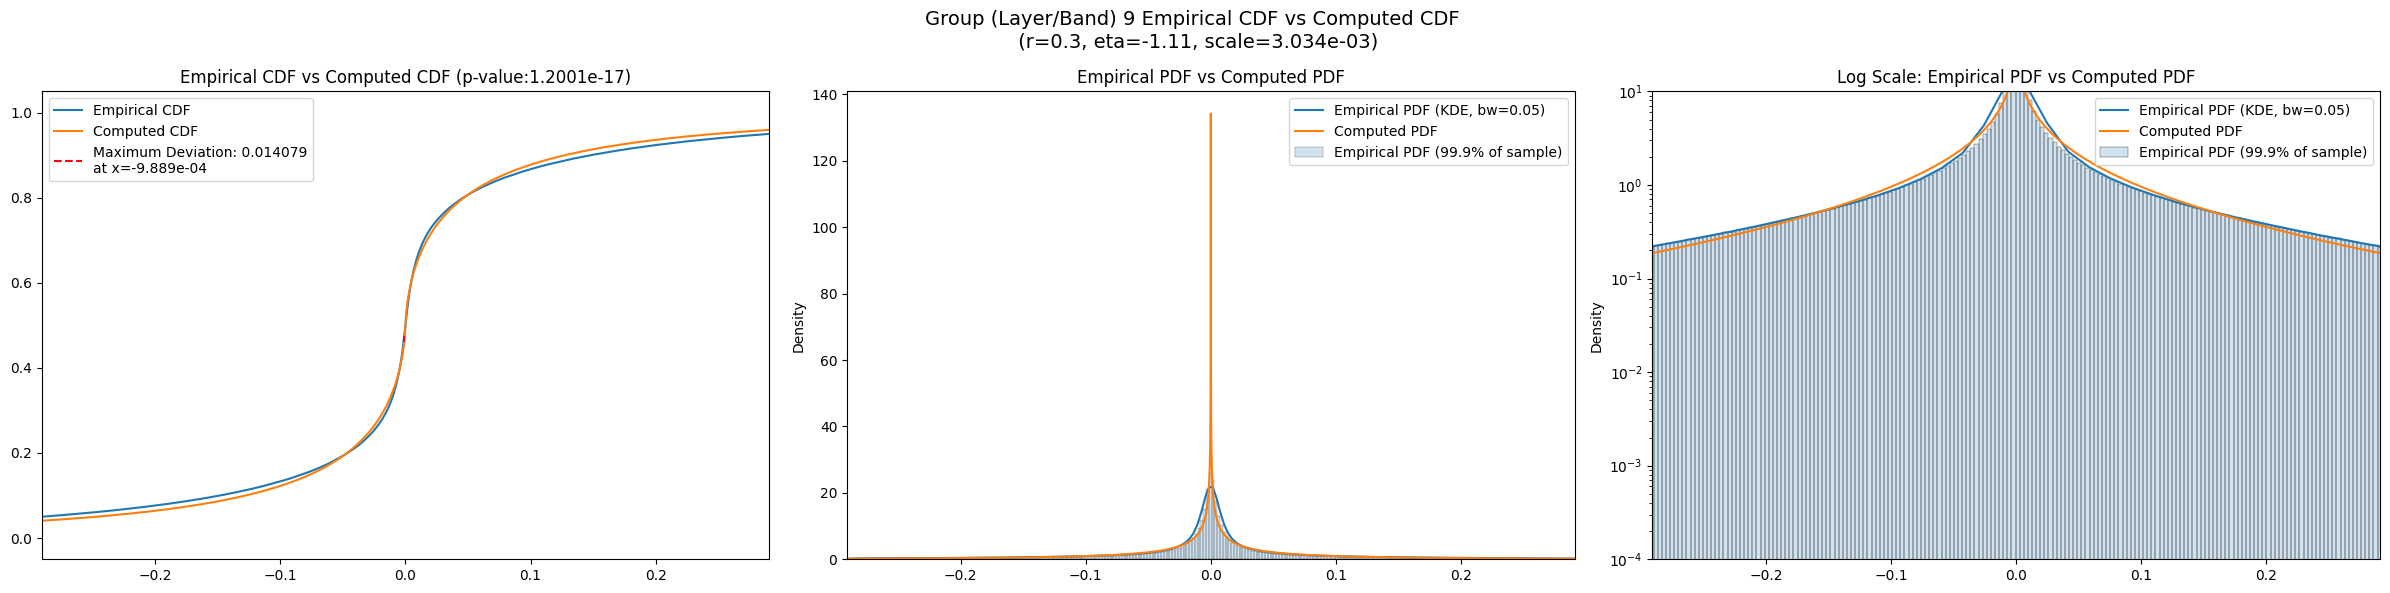

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1218.653100  1124.706900  1316.545000   0.285280    0.000113   
3       290.572480   276.590480   305.190730   1.557775    1.244772   
4        60.992805    57.123000    65.238610   4.609925    3.008300   
5        12.184865    11.295450    13.233427   7.296759    4.731154   
6         2.424221     2.213891     2.720137  13.013254    6.606739   
7         0.520145     0.466576     0.629550  29.398346    8.221189   
8         0.154834     0.136654     0.198347  47.283688    9.892746   
9         0.047433     0.041196     0.060780  54.099040   13.539720   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.616402         2446.0             0.015728        9.2          0.5   
3        1.970670         9784.0             0.007128       13.0         -0.8   
4        8.811685        39136.0             0.005521        1.6         -1.0   
5       20.015156       156544.0             0.004877        2.1         -1.1   
6       51.278920       626176.0             0.018320        0.8         -1.1   
7      170.470540      2504704.0             0.022974        0.8         -1.2   
8      264.616520     10018816.0             0.008124        0.8         -1.2   
9      269.864140     40075264.0             0.015494        0.3         -1.1   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       33.500000              0.020238          2.654660e-01   
3      ...       13.983400              0.032026          3.747090e-09   
4      ...        5.416780              0.048678          4.988560e-81   
5      ...        2.067370              0.059888          0.000000e+00   
6      ...        0.800048              0.066924          0.000000e+00   
7      ...        0.327953              0.073134          0.000000e+00   
8      ...        0.157396              0.078036          0.000000e+00   
9      ...        0.057505              0.099645          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          28.596300             0.023369         1.361050e-01  23.866200   
3          12.384800             0.011015         1.846540e-01  10.357900   
4           4.631980             0.024234         2.123240e-20   3.814030   
5           1.762360             0.034747        1.208380e-164   1.417370   
6           0.685913             0.041333         0.000000e+00   0.544385   
7           0.242349             0.063488         0.000000e+00   0.193165   
8           0.129823             0.056648         0.000000e+00   0.100877   
9           0.049786             0.075069         0.000000e+00   0.038078   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.029347   2.900720e-02          5.750339e-01  
3           0.017178   6.141520e-03          7.000165e-01  
4           0.029735   1.704520e-30          3.717949e-01  
5           0.039010  1.975460e-207          2.694420e-03  
6           0.044162   0.000000e+00         1.518916e-164  
7           0.065554   0.000000e+00          0.000000e+00  
8           0.058924   0.000000e+00          0.000000e+00  
9           0.074387   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.015728                 0.027391          0.015728   
3                 0.007128                 0.013713          0.007128   
4                 0.005521                 0.006861          0.004623   
5                 0.004877                 0.003431          0.004594   
6                 0.018320                 0.001716          0.017370   
7                 0.022974                 0.000858          0.019976   
8                 0.008124                 0.000429          0.007415   
9                 0.015494                 0.000215          0.014079   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.020238             0.023369       0.029347  
3                  0.032026             0.011015       0.017178  
4                  0.048678             0.024234       0.029735  
5                  0.059888             0.034747       0.039010  
6                  0.066924             0.041333       0.044162  
7                  0.073134             0.063488       0.065554  
8                  0.078036             0.056648       0.058924  
9                  0.099645             0.075069       0.074387

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta   best_scale  \
layer                                                                        
2             1218.653100          0.015728     9.2      0.50  1868.632480   
3              290.572480          0.007128    13.0     -0.80   729.705577   
4               60.992805          0.004623     2.0     -1.02   186.357619   
5               10.767020          0.004594     1.7     -1.09    35.796234   
6                1.858795          0.017370     1.1     -1.13     5.436470   
7                0.520145          0.019976     1.1     -1.23     2.064057   
8                0.140406          0.007415     0.6     -1.17     0.204071   
9                0.047433          0.014079     0.3     -1.11     0.003034   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                    200.0  
6                    450.0  
7                      0.0  
8                     50.0  
9                      0.0

In [21]:
eng.quit()